In [1]:
from WingWatch.Intersections.detection import Detection
from WingWatch.Intersections import tri
import trimesh
import pycork
import pandas as pd
import numpy as np
import WingWatch.Intersections.physicalTrackLimiter as PTL
from WingWatch.Equipment import station
from WingWatch.Equipment import antenna
from WingWatch.Tools import translation,spheres
from WingWatch.Tools import point_check as pc
import matplotlib.pyplot as plt
import scipy.spatial as ss

test_data_file = 'Fake_Calibration_Data.csv'
df = pd.read_csv(test_data_file)


Station_1 = station.Station('Station_1',41.1479, -71.5901)
Station_1_Comp_Data = pd.read_csv(test_data_file)
Station_2_pos = translation.convert_back_to_lla([0,-200,0],Station_1.lat,Station_1.long,Station_1.alt)
Station_3_pos = translation.convert_back_to_lla([100*np.sqrt(3),-100,0],Station_1.lat,Station_1.long,Station_1.alt)


freq_of_antenna_MHz = 434
antenna_number = '1'
antenna_type = 'test'
bearing_of_antenna = 0 


a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_1_Comp_Data)
Station_1.add_antenna(a1)

Station_2 = station.Station('Station_2',Station_2_pos[0], Station_2_pos[1])
Station_2_Comp_Data = pd.read_csv(test_data_file)


a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_2_Comp_Data)
Station_2.add_antenna(a1)




Station_3 = station.Station('Station_3',Station_3_pos[0], Station_3_pos[1])
Station_3_Comp_Data = pd.read_csv(test_data_file)

a1 = antenna.Antenna(antenna_number,antenna_type,bearing_of_antenna,freq_of_antenna_MHz)
a1.assign_pattern(Station_3_Comp_Data)
Station_3.add_antenna(a1)


1 added to Station_1's antennas.
1 added to Station_2's antennas.
1 added to Station_3's antennas.


In [2]:
df_detections = pd.read_csv('straight_walk_Detections.csv')
df_walk = pd.read_csv('straight_walk.csv')


#first step, generate all of the single point detections
g = 0 
points_to_follow = []
cx_cent = []
cy_cent = []
for i in range(len(df_detections['Station 1'])):
    det1 = Detection(Station_1,df_detections['Station 1'][i],1)
    det2 = Detection(Station_2,df_detections['Station 2'][i],1)
    det3 = Detection(Station_3,df_detections['Station 3'][i],1)
    data_to_send_through = [det1,det2,det3]
    intersections,hull_of_intersections = tri.overlap_of_three_radiation_patterns(data_to_send_through)
    points_to_follow.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cz = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,2])
    cx_cent.append(cx)
    cy_cent.append(cy)
    g += pc.point_in_hull(np.array([df_walk.iloc[i].X,df_walk.iloc[i].Y,df_walk.iloc[i].Z]),hull_of_intersections,tolerance=2.5)


#g should be the same value as the len of the detections

In [3]:
import WingWatch.Tools.spheres as sph

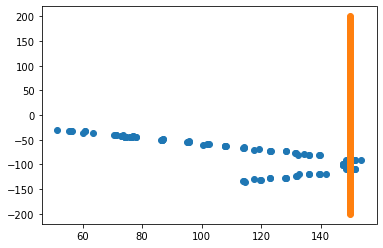

In [4]:
plt.scatter(cx_cent,cy_cent)
plt.scatter(df_walk.X,df_walk.Y)

In [5]:
cx_appv = cx_cent[0:3]
cy_appv = cy_cent[0:3]

radius_list_oldest = []
for i in range(len(points_to_follow)):
    V = ss.ConvexHull(points_to_follow[i]).volume
    radius = sph.find_radius_from_vol(V)
    radius_list_oldest.append(radius)


In [6]:
cx_new = []
cy_new = []
points_to_follow_new = [points_to_follow[0]]
cx_new.append(cx_cent[0])
cy_new.append(cy_cent[0])

i = 1

intersections,hull_of_intersections = PTL.check_constraints(points_to_follow[i-1],points_to_follow[i],5,i)
points_to_follow_new.append(intersections)


radius_list = []
for i in range(len(points_to_follow_new)):
    V = ss.ConvexHull(points_to_follow_new[i]).volume
    radius = sph.find_radius_from_vol(V)
    radius_list.append(radius)


In [7]:
radius_list

[236.87094998957127, 223.66948172928596]

In [ ]:
cx_new = []
cy_new = []
points_to_follow_new = []

for i in range(len(points_to_follow)):
    if i == 0: 
        cx_new.append(cx_cent[i])
        cy_new.append(cy_cent[i])
        points_to_follow_new.append(points_to_follow[i])
        continue
    print(i)
    intersections,hull_of_intersections = PTL.check_constraints(points_to_follow_new[i-1],points_to_follow[i],5,1)
    points_to_follow_new.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cx_new.append(cx)
    cy_new.append(cy)

1
2
3
4
5
6
7
8
9
10
11


In [ ]:
i

In [ ]:
radius_list = []
for i in range(len(points_to_follow_new)):
    V = ss.ConvexHull(points_to_follow_new[i],qhull_options='Q12').volume
    radius = sph.find_radius_from_vol(V)
    radius_list.append(radius)

In [ ]:
radius_list

In [ ]:
df_detections.idxmin()

In [ ]:
df_detections.min()

In [ ]:
import matplotlib.pyplot as plt

df_walk = pd.read_csv('straight_walk.csv')



# Example coordinates and radii
x_coords = cx_cent
y_coords = cy_cent
radii = radius_list

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each circle
for x, y, radius in zip(x_coords, y_coords, radii):
    circle = plt.Circle((x, y), radius, edgecolor='blue', facecolor='none')  # Create a circle
    ax.add_patch(circle)  # Add the circle to the plot

# Set axis limits (for proper circle display)
ax.set_xlim(min(x_coords) - max(radii), max(x_coords) + max(radii))
ax.set_ylim(min(y_coords) - max(radii), max(y_coords) + max(radii))
ax.set_aspect('equal', 'box')  # Ensure the aspect ratio is equal


plt.scatter(0,0,label='Station 1')
plt.scatter(0,-200,label='Station 2')
plt.scatter(100*np.sqrt(3),-100,label='Station 3')
plt.scatter(df_walk.X,df_walk.Y, label='Detection Walk')


# Show plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

df_walk = pd.read_csv('straight_walk.csv')



# Example coordinates and radii
x_coords = cx_cent[60:80]
y_coords = cy_cent[60:80]
radii = radius_list[60:80]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot each circle
for x, y, radius in zip(x_coords, y_coords, radii):
    circle = plt.Circle((x, y), radius, edgecolor='blue', facecolor='none')  # Create a circle
    ax.add_patch(circle)  # Add the circle to the plot

# Set axis limits (for proper circle display)
ax.set_xlim(min(x_coords) - max(radii), max(x_coords) + max(radii))
ax.set_ylim(min(y_coords) - max(radii), max(y_coords) + max(radii))
ax.set_aspect('equal', 'box')  # Ensure the aspect ratio is equal


plt.scatter(0,0,label='Station 1')
plt.scatter(0,-200,label='Station 2')
plt.scatter(100*np.sqrt(3),-100,label='Station 3')
plt.scatter(df_walk.X,df_walk.Y, label='Detection Walk')


# Show plot
plt.show()

In [ ]:
plt.scatter(cx_cent,cy_cent)
plt.scatter(cx_new,cy_new)
plt.scatter(df_walk.X,df_walk.Y)

In [ ]:
plt.scatter(intersections[:,0],intersections[:,1])

cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])

#plt.scatter(cx_cent,cy_cent)
plt.scatter(df_walk.X,df_walk.Y)

plt.scatter(cx,cy)

In [ ]:
df_detections.idxmin()

In [ ]:
cx_new = []
cy_new = []
points_to_follow_new = []

for i in range(71,len(points_to_follow)):
    #for i in range(3):
    if i == 0: 
        cx_new.append(cx_cent[i])
        cy_new.append(cy_cent[i])
        continue
    intersections,hull_of_intersections = PTL.check_constraints(points_to_follow[i-1],points_to_follow[i],5,i)
    points_to_follow_new.append(intersections)
    cx = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,0])
    cy = np.mean(hull_of_intersections.points[hull_of_intersections.vertices,1])
    cx_new.append(cx)
    cy_new.append(cy)

In [ ]:
radius_list_new = []
for i in range(len(points_to_follow_new)):
    V = ss.ConvexHull(points_to_follow_new[i],qhull_options='Q12').volume
    radius = sph.find_radius_from_vol(V)
    radius_list_new.append(radius)

In [ ]:
radius_list_new

In [ ]:
radius_list_new

In [ ]:
radius_list[70:]

In [ ]:
radius_list_oldest[70:]